In [128]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
from astropy.time import Time
import os


from bokeh.plotting import output_notebook, figure, show
from bokeh.models import HoverTool, tools,ColumnDataSource, Whisker
output_notebook()


from gatspy.periodic import LombScargleFast, LombScargle


import matplotlib.pyplot as plt
%matplotlib widget
# use seaborn for plot styles
import seaborn; seaborn.set()

Loading BokehJS ...

In [129]:
def getobjectdata(datafile,index,name='name'):
    command = "sed '{}q;d'  {}".format(index+1,datafile)
    print(command)
    datastring = ! {command}
    datalist = datastring[0].split()
    print(datalist[2:4])
    return datalist



def getvegamaganddates(data,columnfile,name):
    vegamagindex = np.arange(28,6568,13)
    
    
    vegamaglist = np.array([float(data[i]) for i in vegamagindex])
    vegamaglisterrors = np.array([float(data[i+2]) for i in vegamagindex])
    
    columns = []
    with open(columnfile) as filecol:
        for line in filecol:
            columns.append(line)
    listanames = []
    dates = []
    times =[]
    nameobject = []
    namel=[]

    for i in vegamagindex:
        initname = columns[i].find('Try/u')
        namefits = columns[i][initname:initname+23]
        listanames.append(namefits)
        fit = fits.open(namefits+'.fits')
        dates.append(fit[0].header['DATE-OBS'])
        times.append(fit[0].header['TIME-OBS'])
        namel.append(name)
    datesobs = [['{}T{}'.format(i,j)] for i,j in zip(dates,times)]

    d = np.array(datesobs)
    t = Time(d)
    namel = np.array(namel)
       
    return vegamaglist, vegamaglisterrors,t, d, namel


def createdatadiccomplete(data,columnfile):
    vegamag,vegamagerrros, timelist, observationname = getvegamaganddates(data,columnfile)
    datadic = {'time':timelist.datetime64,
               'VEGAMAG':vegamag,
               'obnames':observationname,
                'errorsmag':vegamagerrros}
    return datadic
            
def createdatadicclean(datafile,index,columnfile,name='name'):
    dataobject = getobjectdata(datafile,index)
    vegamag,vegamagerrros, timelist, observationname, namelist = getvegamaganddates(dataobject,columnfile,name)
    goodvegamagindex = np.where(vegamag < 99)

    datadic = {'time':timelist.datetime64[goodvegamagindex],
               'VEGAMAG':vegamag[goodvegamagindex],
               'obnames':observationname[goodvegamagindex],
                'errorsmag':vegamagerrros[goodvegamagindex],
               'upper':vegamag[goodvegamagindex] + vegamagerrros[goodvegamagindex] ,
              'lower':vegamag[goodvegamagindex] - vegamagerrros[goodvegamagindex],
              'name':namelist[goodvegamagindex]}
    return datadic


def createdatadicclean(datafile,index,columnfile,name='name',timeformat='datetime64'):
    dataobject = getobjectdata(datafile,index)
    vegamag,vegamagerrros, timelist, observationname, namelist = getvegamaganddates(dataobject,columnfile,name)
    goodvegamagindex = np.where(vegamag < 99)
    if timeformat == 'datetime64':
        timelist2 = timelist.datetime64[goodvegamagindex]
    elif timeformat == 'mjd':
        timelist2 = timelist.mjd[goodvegamagindex]

    datadic = {'time':timelist2,
               'VEGAMAG':vegamag[goodvegamagindex],
               'obnames':observationname[goodvegamagindex],
                'errorsmag':vegamagerrros[goodvegamagindex],
               'upper':vegamag[goodvegamagindex] + vegamagerrros[goodvegamagindex] ,
              'lower':vegamag[goodvegamagindex] - vegamagerrros[goodvegamagindex],
              'name':namelist[goodvegamagindex]}
    return datadic


def plotlb(outputfile,index,columnfile,name='',plot=True):
    datagoodmjd=  createdatadicclean(outputfile,index,columnfile,name=name,timeformat='mjd')
    
    
    t, mag, dmag = datagoodmjd['time'], datagoodmjd['VEGAMAG'],datagoodmjd['errorsmag']

        # Choose a period grid
    periods = np.linspace(0.2, 1.4, 4000)
    ang_freqs = 2 * np.pi / periods

    # compute the (unnormalized) periodogram
    # note pre-centering of y values!
    power = lombscargle(t.flatten(), mag - mag.mean(), ang_freqs)

    # normalize the power
    N = len(t.flatten())
    power *= 2 / (N * mag.std() ** 2)
    if plot == True:
        # plot the results
        fig, ax = plt.subplots()
        ax.plot(periods, power)
        ax.set(ylim=(0, 0.8), xlabel='period (days)',
               ylabel='Lomb-Scargle Power');
    return periods,power
    
def plotlc(outputfile,indexlist,columnfile,namelist=''):
    colorlist = ['red','blue','green','yellow']
    p = figure(plot_width=900, plot_height=500, title='',active_drag='pan', active_scroll='wheel_zoom',
                  x_axis_type='datetime',y_axis_label='VEGAMAG',x_axis_label='Date_Obs')
    for i,indexnumber in enumerate(indexlist):
        color = colorlist[i]
        
        datagood = createdatadicclean(outputfile,indexnumber,columnfile,name=namelist[i])

        source = ColumnDataSource(data=datagood)
   


        


        #Tool to get wavelength
        hover2 = HoverTool(
                tooltips=[
                    ('Date', '(@obnames)')
                ]
            )


        p.add_tools(hover2)



        # add a circle renderer with a size, color, and alpha
        p.circle('time','VEGAMAG', source=source, color=color, name='name',legend='name')
        p.add_layout(
            Whisker(source=source, base="time", upper="upper", lower="lower")
        )






    show(p)

def plotphase(outputfile,index,columnfile,name='',plot=False,periodmax=99.99):
    nameob= name
    period,power = plotlb(outputfile,index,columnfile,name=nameob,plot=plot)
    datagoodmjd=  createdatadicclean(outputfile,index,columnfile,name=name,timeformat='mjd')
    
    
    t, mag, dmag = datagoodmjd['time'], datagoodmjd['VEGAMAG'],datagoodmjd['errorsmag']
    indexmax = np.where(power == power.max())
    if periodmax == 99.99:
        periodmax = periods[indexmax]
    print(periodmax)

    # Compute phases of the obsevations
    phase = (t.flatten() / periodmax) % 1

    # Plot the phased data & model
    fig, ax = plt.subplots()

    
    ax.errorbar(phase, mag, dmag, fmt='.k', ecolor='gray', alpha=0.5)
    #ax.invert_yaxis();
    plt.show()

In [130]:
outputfile = 'outdir/out.photo'
columnfile = 'outdir/out.columns'

In [131]:
datagood230 = createdatadicclean(outputfile,230,columnfile,name='230')
datagood737 =  createdatadicclean(outputfile,737,columnfile,name='737')


sed '231q;d'  outdir/out.photo
['512.14', '128.26']
sed '738q;d'  outdir/out.photo
['515.39', '125.65']


In [132]:
%matplotlib widget
import matplotlib.pyplot as plt
plt.plot(datagood230['VEGAMAG'],datagood737['VEGAMAG'],'.')
plt.show()

FigureCanvasNbAgg()

# Plot

In [135]:

source = ColumnDataSource(data={'x':datagood230['VEGAMAG'],'y':datagood737['VEGAMAG']})
source2 = ColumnDataSource(data=datagood737)


p = figure(plot_width=900, plot_height=500, title='',active_drag='pan', active_scroll='wheel_zoom',
          x_axis_type='datetime',y_axis_label='VEGAMAG',x_axis_label='Date_Obs')


#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@obnames)')
        ]
    )

        
p.add_tools(hover2)



# add a circle renderer with a size, color, and alpha
p.circle('x','y', source=source, color='red', name='name',legend='name')





show(p)

In [6]:
datagood737mjd =  createdatadicclean(outputfile,737,columnfile,name='737',timeformat='mjd')



sed '738q;d'  outdir/out.photo
['515.39', '125.65']


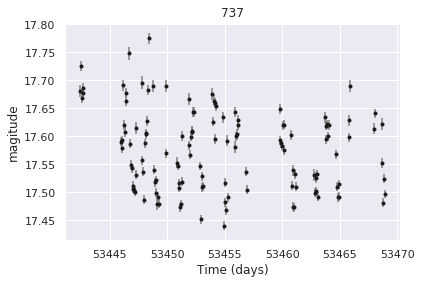

In [14]:
fig, ax = plt.subplots()

t737, mag737, dmag737 = datagood737mjd['time'], datagood737mjd['VEGAMAG'],datagood737mjd['errorsmag']

ax.errorbar(t737, mag737, dmag737,  fmt='.k', ecolor='gray')
ax.set(xlabel='Time (days)', ylabel='magitude',
       title=datagood737mjd['name'][0])
#ax.invert_yaxis();
plt.show()

# Scipy

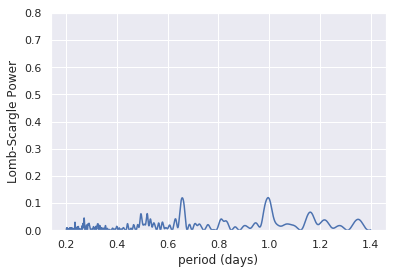

In [37]:
from scipy.signal import lombscargle

# Choose a period grid
periods = np.linspace(0.2, 1.4, 4000)
ang_freqs = 2 * np.pi / periods

# compute the (unnormalized) periodogram
# note pre-centering of y values!
power = lombscargle(t737.flatten(), mag737 - mag737.mean(), ang_freqs)

# normalize the power
N = len(t737.flatten())
power *= 2 / (N * mag737.std() ** 2)

# plot the results
fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(ylim=(0, 0.8), xlabel='period (days)',
       ylabel='Lomb-Scargle Power');




In [41]:
idx = (-power).argsort()[:100]
periods[idx]

array([0.99579895, 0.99609902, 0.99549887, 0.9963991 , 0.9951988 ,
       0.99669917, 0.99489872, 0.99699925, 0.99459865, 0.99729932,
       0.99429857, 0.65701425, 0.65731433, 0.9975994 , 0.9939985 ,
       0.65671418, 0.6576144 , 0.6564141 , 0.99789947, 0.65791448,
       0.99369842, 0.65611403, 0.99339835, 0.65821455, 0.99819955,
       0.99309827, 0.65581395, 0.99849962, 0.65851463, 0.9927982 ,
       0.9987997 , 0.6588147 , 0.65551388, 0.99249812, 0.99909977,
       0.65911478, 0.99219805, 0.6552138 , 0.99939985, 0.99189797,
       0.65941485, 0.65491373, 0.99969992, 0.9915979 , 0.65971493,
       1.        , 0.99129782, 0.65461365, 0.99099775, 1.00030008,
       0.660015  , 0.99069767, 0.65431358, 1.00060015, 0.9903976 ,
       0.66031508, 1.00090023, 0.6540135 , 0.99009752, 0.66061515,
       1.0012003 , 0.98979745, 0.65371343, 1.00150038, 0.98949737,
       0.66091523, 0.9891973 , 1.00180045, 0.65341335, 0.6612153 ,
       0.98889722, 1.00210053, 0.98859715, 0.65311328, 1.00240

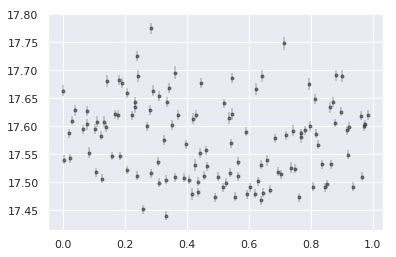

In [42]:

indexmax = np.where(power == power.max())
periodmax = periods[indexmax]
#print(periodmax)
periodmax = 0.65

# Compute phases of the obsevations
phase737 = (t737.flatten() / periodmax) % 1

# Plot the phased data & model
fig, ax = plt.subplots()


ax.errorbar(phase737, mag737, dmag737, fmt='.k', ecolor='gray', alpha=0.5)
plt.show()

# Example data from Linear and Jave

https://jakevdp.github.io/blog/2015/06/13/lomb-scargle-in-python/

In [101]:
from astroML.datasets import fetch_LINEAR_sample
LINEAR_data = fetch_LINEAR_sample()
star_id = 10040133
t, mag, dmag = LINEAR_data.get_light_curve(star_id).T

fig, ax = plt.subplots()
ax.errorbar(t, mag, dmag, fmt='.k', ecolor='gray')
ax.set(xlabel='Time (days)', ylabel='magitude',
       title='LINEAR object {0}'.format(star_id))
#ax.invert_yaxis();
plt.show()

FigureCanvasNbAgg()

In [102]:
from scipy.signal import lombscargle

# Choose a period grid
periods = np.linspace(0.2, 1.4, 4000)
ang_freqs = 2 * np.pi / periods

# compute the (unnormalized) periodogram
# note pre-centering of y values!
power = lombscargle(t, mag - mag.mean(), ang_freqs)

# normalize the power
N = len(t)
power *= 2 / (N * mag.std() ** 2)

# plot the results
fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(ylim=(0, 0.8), xlabel='period (days)',
       ylabel='Lomb-Scargle Power');




FigureCanvasNbAgg()

In [105]:
indexmax = np.where(power == power.max())
periodmax = periods[indexmax]
#print(periodmax)

# Compute phases of the obsevations
phase = (t.flatten() / periodmax) %1

# Plot the phased data & model
fig, ax = plt.subplots()


ax.errorbar(phase, mag, dmag, fmt='.k', ecolor='gray', alpha=0.5)
#ax.invert_yaxis();
plt.show()

FigureCanvasNbAgg()

# 1179

In [107]:
plotlc(outputfile,[737,230],columnfile,namelist=['737','230'])


sed '738q;d'  outdir/out.photo
['515.39', '125.65']
sed '231q;d'  outdir/out.photo
['512.14', '128.26']


In [87]:
period,power = plotlb(outputfile,1179,columnfile,name='1179')

sed '1180q;d'  outdir/out.photo
['520.61', '248.53']


FigureCanvasNbAgg()

In [98]:
def plotphase(outputfile,index,columnfile,name='',plot=False,periodmax=99.99):
    nameob= name
    period,power = plotlb(outputfile,index,columnfile,name=nameob,plot=plot)
    datagoodmjd=  createdatadicclean(outputfile,index,columnfile,name=name,timeformat='mjd')
    
    
    t, mag, dmag = datagoodmjd['time'], datagoodmjd['VEGAMAG'],datagoodmjd['errorsmag']
    indexmax = np.where(power == power.max())
    if periodmax == 99.99:
        periodmax = periods[indexmax]
    print(periodmax)

    # Compute phases of the obsevations
    phase = (t.flatten() / periodmax) % 1

    # Plot the phased data & model
    fig, ax = plt.subplots()

    
    ax.errorbar(phase, mag, dmag, fmt='.k', ecolor='gray', alpha=0.5)
    #ax.invert_yaxis();
    plt.show()

In [100]:
plotphase(outputfile,1179,columnfile,name='1179',periodmax=0.47)

sed '1180q;d'  outdir/out.photo
['520.61', '248.53']
sed '1180q;d'  outdir/out.photo
['520.61', '248.53']
0.47


FigureCanvasNbAgg()